In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
import scipy.misc
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.visualization import *
from photutils import *
import insight as ih
%matplotlib inline

### Calculating bias

In [2]:
#directories for the bias data
bias_directory_008 = 'data/darks/0.008'
bias_directory_009 = 'data/darks/0.009'

In [3]:
#biases for 0.008 s and 0.009 s exposures 
bias_008,std_008 = ih.bias_calc(bias_directory_008)
bias_009,std_009 = ih.bias_calc(bias_directory_009)

In [4]:
std_err_008 = std_008/np.sqrt(len(os.listdir(bias_directory_008)))
std_err_009 = std_009/np.sqrt(len(os.listdir(bias_directory_009)))

In [5]:
print('For exposure time of 0.008s the average bias is', bias_008)
print('Standard deviation', std_008)
print('Standard error',std_err_008)
print('For exposure time of 0.009s the average bias is', bias_009)
print('Standard deviation',std_009)
print('Standard error',std_err_009)

For exposure time of 0.008s the average bias is 766.3802704883889
Standard deviation 28.476783627343334
Standard error 5.199125585963244
For exposure time of 0.009s the average bias is 766.4963268640007
Standard deviation 28.424245044490817
Standard error 5.189533396974018


### Jupiter Data

In [6]:
jupiter_directory = 'data/jupiter'

In [7]:
jupiter_data = ih.multiple_fits(jupiter_directory)

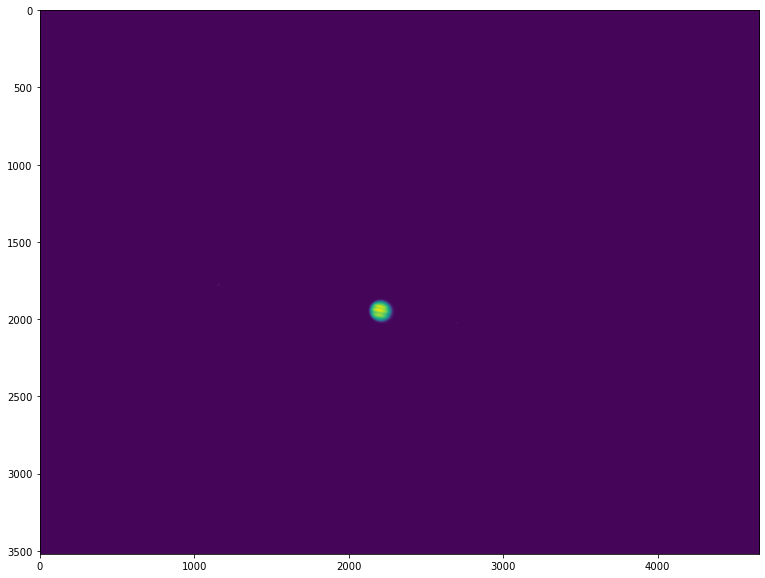

In [8]:
#the first image
plt.figure(figsize = (20,10))
plt.imshow(jupiter_data[0])

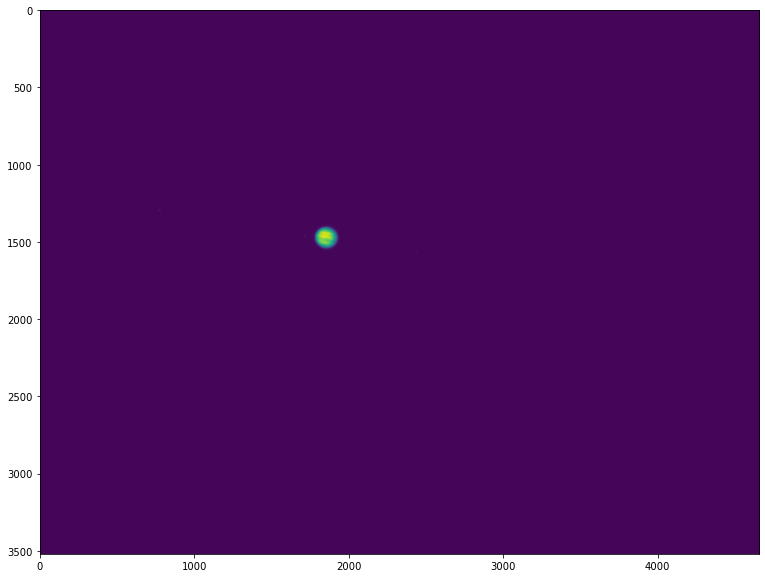

In [9]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_data[21])

In [10]:
jupiter_data = jupiter_data - bias_008

In [11]:
#calculating the centroid of the reference image
x0, y0 = centroid_quadratic(jupiter_data[0], fit_boxsize = 1000)
print(x0,y0)

2198.6748305827 1941.4548058509636


In [12]:
centroids_x,centroids_y = ih.calculate_centroids(jupiter_data)

In [13]:
#calculating positional offsets compared to the reference image
xoffset =  -(centroids_x - x0)
yoffset =  -(centroids_y - y0)

In [14]:
xoffset

array([ 32.95135038,  55.6734321 ,  74.96988243, 111.62709168,
       128.27346698, 156.25114497, 186.46214335, 218.37685254,
       264.1243004 , 282.82268273, 300.50792316, 335.11586839,
       351.75151372, 363.35780234, 377.12516025, 386.65404679,
       390.48152795, 392.22020898, 386.23340337, 365.3923367 ,
       356.51082789])

In [15]:
lintrans = ih.transformation_matrices(xoffset,yoffset)
lintrans[0]

array([[  1.        ,   0.        ,  32.95135038],
       [  0.        ,   1.        , -14.51444314]])

In [16]:
rows, cols = jupiter_data[0].shape[:2] 

In [17]:
new_jupiter_data = ih.image_registration(jupiter_data,lintrans,rows,cols)

In [18]:
ref_img = np.array(jupiter_data[0])
ref_img.shape

(3520, 4656)

In [19]:
#getting out new dataset together
jupiter_centred_data = np.concatenate(([ref_img], new_jupiter_data))

In [20]:
#uncomment if you need to write the centred images to .fits files
#name = 'jupiter'
#jupiter_centred = 'data/jupiter_centred'
#ih.write_to_fits(jupiter_centred,jupiter_centred_data,name)

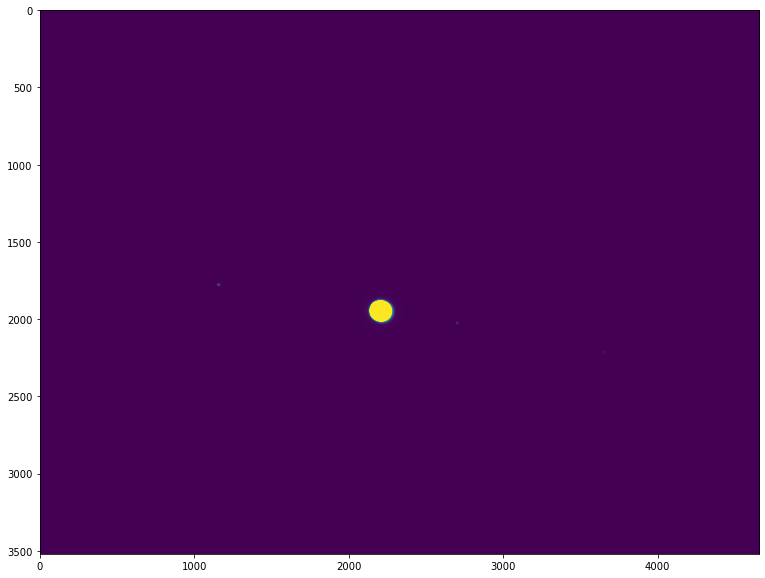

In [21]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[0], vmin = 0, vmax = 10000)

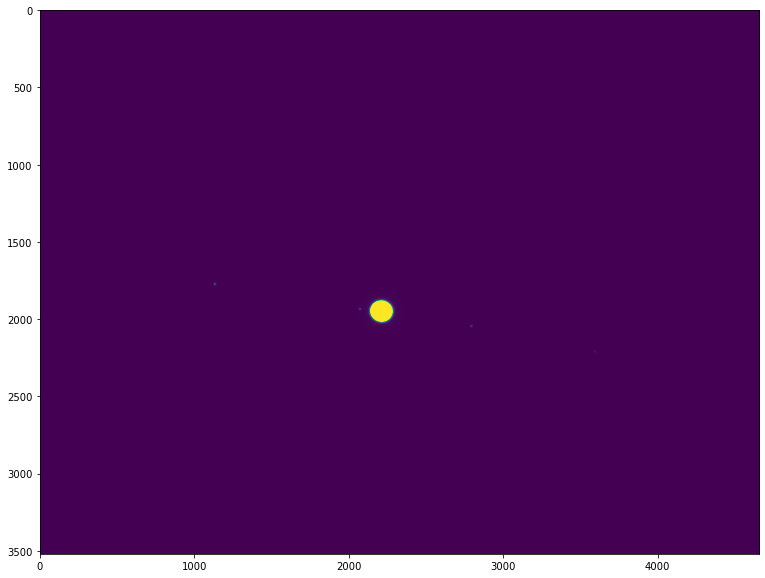

In [22]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[21],vmin = 0, vmax = 10000)

In [23]:
norm = ih.norm_zscale_asinh(jupiter_centred_data)

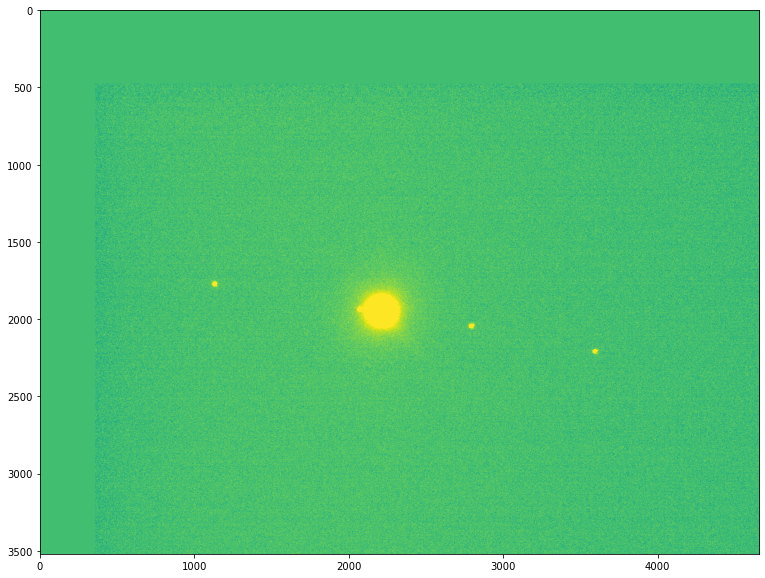

In [24]:
plt.figure(figsize = (20,10))
plt.imshow(jupiter_centred_data[21],norm=norm[21])

In [25]:
ZScaleInterval().get_limits(jupiter_centred_data[21])

(-52.380270488388874, 78.69134047787931)

### Finding the moons

In [36]:
mask = np.zeros(jupiter_centred_data[0].shape, dtype=bool)
mask[1874:2014, 2127:2280] = True
norm = simple_norm(jupiter_centred_data[0], 'sqrt', percent=99.9)
threshold = 1000

In [27]:
moons = ih.find_moons(jupiter_centred_data,mask,threshold)

In [29]:
moons_df = pd.DataFrame(moons)
moons_df.head()

,x_peak,y_peak,peak_value
0,1154,1777,5217.61973
1,2696,2021,3697.61973
2,3644,2211,1121.61973
3,1159,1776,6742.61973
4,2705,2024,4029.11973


In [31]:
Moon_1 = np.array(moons_df[moons_df['x_peak'] < 1500])
Moon_2 = np.array(moons_df[moons_df['x_peak'].between(1500, 2500)])
Moon_3 = np.array(moons_df[moons_df['x_peak'].between(2500, 3500)])
Moon_4 = np.array(moons_df[moons_df['x_peak'] > 3500])

In [32]:
cols = ['x_peak','y_peak','peak_value']
Moon_1_df = pd.DataFrame(Moon_1,columns = cols)
Moon_2_df = pd.DataFrame(Moon_2,columns = cols)
Moon_3_df = pd.DataFrame(Moon_3,columns = cols)
Moon_4_df = pd.DataFrame(Moon_4,columns = cols)

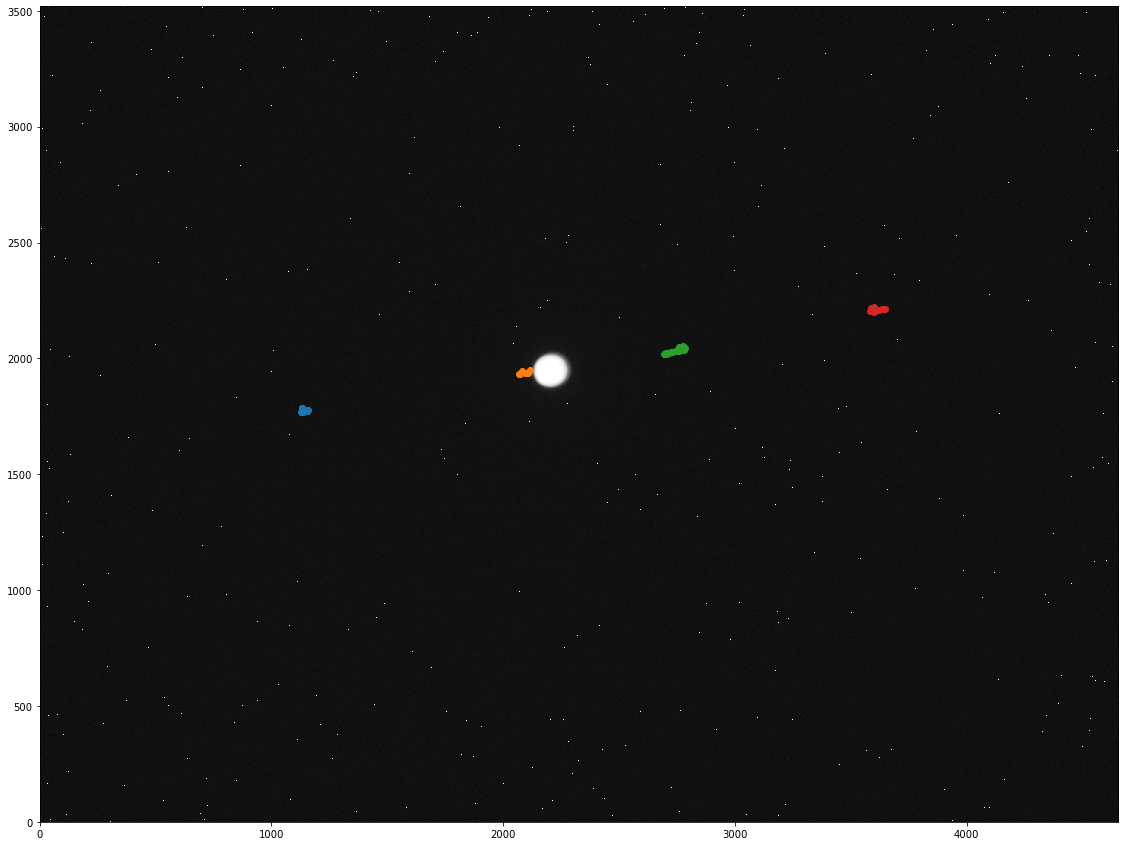

In [37]:
plt.figure(figsize = (20,15))
plt.xlim(0, jupiter_centred_data[0].shape[1]-1)
plt.ylim(0, jupiter_centred_data[0].shape[0]-1)
plt.scatter(Moon_1_df['x_peak'],Moon_1_df['y_peak'])
plt.scatter(Moon_2_df['x_peak'],Moon_2_df['y_peak'])
plt.scatter(Moon_3_df['x_peak'],Moon_3_df['y_peak'])
plt.scatter(Moon_4_df['x_peak'],Moon_4_df['y_peak'])
plt.imshow(jupiter_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

In [34]:
Moon_1_df.to_csv (r'data/moons/moon1.csv', index = False)
Moon_2_df.to_csv (r'data/moons/moon2.csv', index = False)
Moon_3_df.to_csv (r'data/moons/moon3.csv', index = False)
Moon_4_df.to_csv (r'data/moons/moon4.csv', index = False)